In [1]:
!python -V
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Callable


rng = np.random.default_rng(1234)

Python 3.13.3


# Question 1

## (a)

For the model

$$ dX_t = rX_t dt + \sigma X_{t}^\gamma dW_t $$

We note that the associated PDE for the corridor option price $V(t, x)$ is

$$
\begin{align*}
    &\frac{\partial V}{\partial t} + rx \frac{\partial V}{\partial x} + \frac{\sigma^2 x^{2\gamma}}{2} \frac{\partial^2 V}{\partial x^2} - rV = 0 \\
    &\\
    &V(T, x) = 𝟙_{[15, 25]} (x)
\end{align*}
$$

We recall that $V^{m}_{n} = V(m\Delta t, x_\mathrm{min} + n \Delta x)$ and the discretizations for the implicit scheme is given by

$$
\begin{align*}
    \frac{\partial V}{\partial t} &\approx \frac{V^{m}_{n} - V^{m-1}_{n}}{\Delta t} \\
    \frac{\partial V}{\partial x} &\approx \frac{V^{m-1}_{n+1} - V^{m-1}_{n-1}}{2\Delta x} \\
    \frac{\partial^2 V}{\partial x^2} & \approx \frac{V^{m-1}_{n+1} - 2V^{m-1}_{n} + V^{m-1}_{n-1}}{(\Delta x)^2}
\end{align*}
$$

Setting $\chi_n = x_\mathrm{min} + n\Delta x$, this yields the discretization

$$
    \frac{1}{\Delta t} \left( V^{m}_{n} - V^{m-1}_{n} \right) + \frac{r\chi_n}{2\Delta x} \left( V^{m-1}_{n+1} - V^{m-1}_{n-1} \right) + \frac{\sigma^2 \chi_{n}^{2\gamma}}{2(\Delta x)^2} \left( V^{m-1}_{n+1} - 2V^{m-1}_{n} + V^{m-1}_{n-1} \right) - rV^{m-1}_{n} = 0
$$

Now set $\alpha_n = \frac{r \chi_n \Delta t}{2\Delta x}$, $\beta_n = \frac{\sigma^2 \chi_{n}^{2\gamma} \Delta t}{2\Delta x^2}$. Then we arrive at the scheme

$$
\begin{align*}
    V^{m}_{n} &= V^{m-1}_{n-1} \left(\alpha_n - \beta_n \right) \\
    &+ V^{m-1}_{n} \left(1 + r \Delta t + 2\beta_n \right) \\
    &+ V^{m-1}_{n+1} \left(-\alpha_n - \beta_n \right)
\end{align*}
$$
For the boundary conditions, we will use the fact that $V(t, x) = 0$ when $x \notin [15, 25]$, which translates to $V_{N+1}^{k} = V_{0}^{k} = 0$.

Note that this scheme is essentially the linear system $Av^{m-1} = v^{m}$ where the only unknown is $v^{m-1}$.

In [2]:
def implicit_solver(
        *,
        dt: float,
        dx: float,
        r: float,
        gamma: float,
        sigma: float,
        T: float,
        x_range: tuple[float, float],
        payoff: np.ndarray | None = None,
        boundary: Callable[[int], tuple[float, float]] = lambda x: (0, 0)
) -> np.ndarray:
        '''
        x_range is interpreted as `[X_min, X_max]`. Necessarily, x0 should be in x_range.

        This assumes that `T / dt` and `(X_max - X_min) / dx` are integers.

        Payoff is an optional parameter. If not given, then the payoff will be assumed to be 1.
        '''
        # initialize grid and initial conditions
        x_min, x_max = x_range
        M = int(T / dt)
        N = int((x_max - x_min) / dx) + 1

        grid = np.empty((N, M))
        grid[:, -1] = payoff if payoff is not None else np.ones(N)

        # find the matrix A s.t. Av^{m-1} = v^m
        # instead of constructing A explicitly,
        # i will use scipy's "solve_banded" method
        # which requires a 3 x N matrix.
        n = np.arange(1, N+1) # 1, 2, ..., N
        chi = x_min + n * dx
        alpha = (r * chi * dt) / (2 * dx)
        beta = (sigma**2 * chi**(2 * gamma) * dt) / (2 * dx**2)

        upper_diagonal = -alpha - beta
        upper_diagonal = np.delete(upper_diagonal, -1) # remove the last term since it doesn't appear in the scheme
        upper_diagonal = np.insert(upper_diagonal, 0, 0) # for scipy

        diagonal = 1 + r * dt + 2 * beta

        lower_diagonal = alpha - beta
        lower_diagonal = np.delete(lower_diagonal, 0) # remove the first term since it doesn't appear in the scheme
        lower_diagonal = np.append(lower_diagonal, 0) # for scipy

        A_scipy = np.vstack((upper_diagonal, diagonal, lower_diagonal))
        
        # run the scheme
        b = np.zeros(N)
        for i in range(M - 1, 0, -1): # M - 1, ..., 1
                b[0], b[-1] = boundary(i)
                grid[:, i-1] = sp.linalg.solve_banded((1, 1), A_scipy, grid[:, i] + b)

        return grid

In [3]:
implicit_solution = implicit_solver(
    dt=0.01,
    dx=0.02,
    r=0.05,
    gamma=0.8,
    sigma=0.4,
    T=0.5,
    x_range=(15, 25)
)

Implicit: Option Price at t=0, x=20: $0.7661


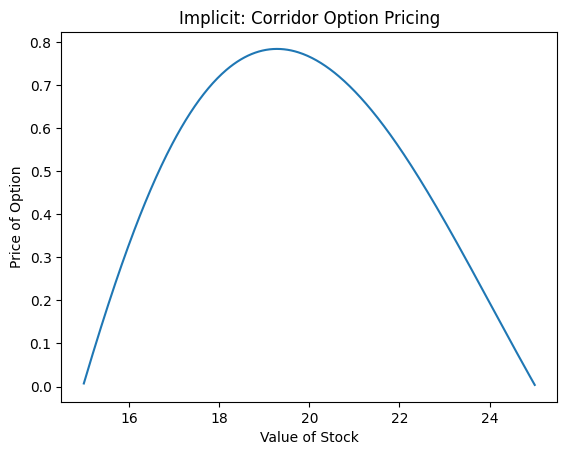

In [4]:
# graph the solution
# 20 = 15 + k 0.02 so k = 5 / 0.02 = 250
print(f'Implicit: Option Price at t=0, x=20: ${implicit_solution[250, 0]:.4f}')

ax = sns.lineplot(x=np.linspace(15, 25, 501), y=implicit_solution[:, 0])
ax.set_xlabel('Value of Stock')
ax.set_ylabel('Price of Option')
ax.set_title('Implicit: Corridor Option Pricing')

plt.show()

## (b)

For the Crank-Nicolson method, we have the following discretization
$$
\begin{align*}
    &\frac{V^{m}_{n} - V^{m-1}_{n}}{\Delta t} +\\
    &r\chi_n \cdot \frac{1}{2} \left( \frac{V^{m-1}_{n+1} - V^{m-1}_{n-1}}{2\Delta x} + \frac{V^{m}_{n+1} - V^{m}_{n-1}}{2\Delta x} \right) +\\
    &\frac{\sigma^2 \chi_{n}^{2\gamma}}{2} \cdot \frac{1}{2} \left( \frac{V^{m-1}_{n+1} - 2V^{m-1}_{n} + V^{m-1}_{n-1}}{(\Delta x)^2} + \frac{V^{m}_{n+1} - 2V^{m}_{n} + V^{m}_{n-1}}{(\Delta x)^2} \right) + \\ 
    &-r \cdot \frac{1}{2}\left( V^{m-1}_{n}  + V^{m}_{n} \right) = 0
\end{align*}
$$

Keeping the definitions $\alpha_n = \frac{r \chi_n \Delta t}{2\Delta x}$, $\beta_n = \frac{\sigma^2 \chi_{n}^{2\gamma} \Delta t}{2\Delta x^2}$, we have the scheme

$$
\begin{align*}
    &V^{m-1}_{n-1} \left(\frac{\alpha_n}{2} - \frac{\beta_n}{2} \right) + V^{m-1}_{n} \left(1 + \frac{r \Delta t}{2} + \beta_n \right) + V^{m-1}_{n+1} \left(-\frac{\alpha_n}{2} - \frac{\beta_n}{2} \right) \\
    =&V^{m}_{n-1} \left( -\frac{\alpha_n}{2} + \frac{\beta_n}{2} \right) + V^{m}_{n} \left(1 - \frac{r \Delta t}{2} - \beta_n \right) + V^{m}_{n+1} \left(\frac{\alpha_n}{2} + \frac{\beta_n}{2}\right)
\end{align*}
$$

We will keep the boundary condition $V^{k}_{N+1} = V^{k}_{0} = 0$ for every $k$.

Note that this scheme is essentially the linear system $Av^{m-1} = Bv^m$ where the only unknown is $v^{m-1}$

In [5]:
def crank_nicolson_solver(
    *,
    dt: float,
    dx: float,
    r: float,
    gamma: float,
    sigma: float,
    T: float,
    x_range: tuple[float, float],
    payoff: np.ndarray | None = None,
    boundary: Callable[[int], tuple[float, float]] = lambda x: (0, 0)
) -> np.ndarray:
    '''
    x_range is interpreted as `[X_min, X_max]`. Necessarily, x0 should be in x_range.
    This assumes that `T / dt` and `(X_max - X_min) / dx` are integers.
    
    Payoff is an optional parameter. If not given, then the payoff will be assumed to be 1.
    Boundary is an optional parameter. It is a function that is given the current index and returns
    the boundary conditions for (0, N+1), which is then added to the RHS of the linear system. Defaults to 0.
    '''
    # initialize grid and initial conditions
    x_min, x_max = x_range
    M = int(T / dt)
    N = int((x_max - x_min) / dx) + 1

    grid = np.empty((N, M))
    grid[:, -1] = payoff if payoff is not None else np.ones(N)

    # find the matrix A
    # instead of constructing A explicitly,
    # i will use scipy's "solve_banded" method
    # which requires a 3 x N matrix.
    n = np.arange(1, N+1) # 1, 2, ..., N
    chi = x_min + n * dx
    alpha = (r * chi * dt) / (2 * dx)
    beta = (sigma**2 * chi**(2 * gamma) * dt) / (2 * dx**2)

    A_upper_diagonal = (-alpha - beta) / 2
    A_upper_diagonal = np.delete(A_upper_diagonal, -1) # remove the last term since it doesn't appear in the scheme

    A_diagonal = 1 + r * dt / 2 + beta

    A_lower_diagonal = (alpha - beta) / 2
    A_lower_diagonal = np.delete(A_lower_diagonal, 0) # remove the first term since it doesn't appear in the scheme

    A_scipy = np.vstack( # the modifications of the diagonals is purely for formatting purposes
        (
            np.insert(A_upper_diagonal, 0, 0), 
            A_diagonal, 
            np.append(A_lower_diagonal, 0)
        )
    )

    # now construct B
    B_upper_diagonal = -A_upper_diagonal
    B_diagonal = 1 - r * dt / 2 - beta
    B_lower_diagonal = -A_lower_diagonal

    B = np.diag(B_diagonal) + np.diag(B_upper_diagonal, k=1) + np.diag(B_lower_diagonal, k=-1)

    b = np.zeros(N)
    for i in range(M - 1, 0, -1): # M - 1, ..., 1
        b[0], b[-1] = boundary(i)
        grid[:, i-1] = sp.linalg.solve_banded((1, 1), A_scipy, B @ grid[:, i] + b)

    return grid

In [6]:
cn_solution = crank_nicolson_solver(
    dt=0.01,
    dx=0.02,
    r=0.05,
    gamma=0.8,
    sigma=0.4,
    T=0.5,
    x_range=(15, 25)
)

Crank-Nicolson: Option Price at t=0, x=20: $0.7653


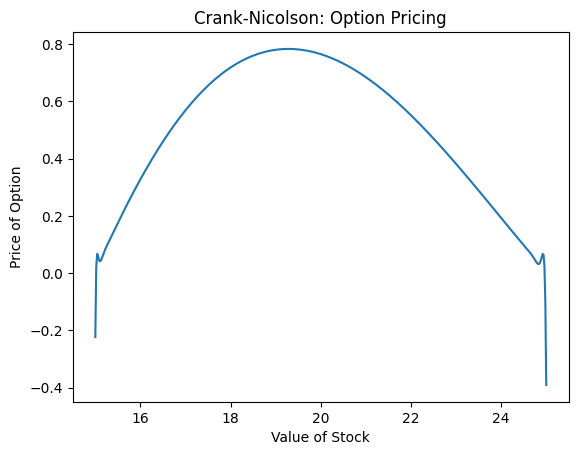

In [7]:
# graph the solution
# 20 = 15 + k 0.02 so k = 5 / 0.02 = 250
print(f'Crank-Nicolson: Option Price at t=0, x=20: ${cn_solution[250, 0]:.4f}')

ax = sns.lineplot(x=np.linspace(15, 25, 501), y=cn_solution[:, 0])
ax.set_xlabel('Value of Stock')
ax.set_ylabel('Price of Option')
ax.set_title('Crank-Nicolson: Option Pricing')

plt.show()

*I additionally tested this on a BS Call and it worked fine, so the implementation is good*

We note that there is some numerical instability since, for $\Delta t = 0.01$ and $\Delta x = 0.02$, $\frac{\Delta t}{\Delta x^2} = 25 > \frac{1}{2}$. Despite this, both solvers are within 1 cent of each other at $V(0, 20)$, so they perform roughly the same in this region (with the implicit solver having better global performance). Compared to Q1 from HW1, this performance is within 5 cents of the antithetic sampler, so they are performing very similarly.

## (c)

To simulate the compound option, we first must simulate the underlying call option prices. This has payoff

$$
    \max\{ x - 20, 0\}
$$

I will use the boundary condition $\frac{\partial^2 C}{\partial x^2} = 0$ on both boundaries, as this condition makes intuitive sense since call options become roughly linear at the endpoints, and the price of a CEV call has no closed form. This amounts to $C^{k}_{N+1} = 2C^{k}_{N} - C^{k}_{N-1}$, $C^{k}_{0} = 2C^{k}_{1} - C^{k}_{2}$.

Moreover, I will use the range $[10, 30]$, $\Delta x = 0.02, \Delta t = 0.01$. This amounts to 1001 points for $x$

In [8]:
# the 2nd derivative condition requires me to directly edit the matrix unfortunately,
# so i have to slightly modify them in the solver
def compound_implicit_solver(
        *,
        dt: float,
        dx: float,
        r: float,
        gamma: float,
        sigma: float,
        T: float,
        x_range: tuple[float, float],
        payoff: np.ndarray | None = None,
        boundary: Callable[[int], tuple[float, float]] = lambda x: (0, 0)
) -> np.ndarray:
        '''
        x_range is interpreted as `[X_min, X_max]`. Necessarily, x0 should be in x_range.

        This assumes that `T / dt` and `(X_max - X_min) / dx` are integers.

        Payoff is an optional parameter. If not given, then the payoff will be assumed to be 1.
        '''
        # initialize grid and initial conditions
        x_min, x_max = x_range
        M = int(T / dt)
        N = int((x_max - x_min) / dx) + 1

        grid = np.empty((N, M))
        grid[:, -1] = payoff if payoff is not None else np.ones(N)

        # find the matrix A s.t. Av^{m-1} = v^m
        # instead of constructing A explicitly,
        # i will use scipy's "solve_banded" method
        # which requires a 3 x N matrix.
        n = np.arange(1, N+1) # 1, 2, ..., N
        chi = x_min + n * dx
        alpha = (r * chi * dt) / (2 * dx)
        beta = (sigma**2 * chi**(2 * gamma) * dt) / (2 * dx**2)

        upper_diagonal = -alpha - beta
        c_upper_term = upper_diagonal[-1]
        upper_diagonal = np.delete(upper_diagonal, -1) # remove the last term since it doesn't appear in the scheme
        upper_diagonal = np.insert(upper_diagonal, 0, 0) # for scipy

        diagonal = 1 + r * dt + 2 * beta

        lower_diagonal = alpha - beta
        c_lower_term = lower_diagonal[0]
        lower_diagonal = np.delete(lower_diagonal, 0) # remove the first term since it doesn't appear in the scheme
        lower_diagonal = np.append(lower_diagonal, 0) # for scipy

        # incorporate the boundary conditions into A
        # upper boundary
        diagonal[-1] += 2 * c_upper_term
        lower_diagonal[-2] -= c_upper_term

        # lower boundary
        diagonal[0] += 2 * c_lower_term
        upper_diagonal[1] -= c_lower_term
        A_scipy = np.vstack((upper_diagonal, diagonal, lower_diagonal))
        
        # run the scheme
        b = np.zeros(N)
        for i in range(M - 1, 0, -1): # M - 1, ..., 1
                b[0], b[-1] = boundary(i)
                grid[:, i-1] = sp.linalg.solve_banded((1, 1), A_scipy, grid[:, i] + b)

        return grid

In [9]:
def compound_crank_nicolson_solver(
    *,
    dt: float,
    dx: float,
    r: float,
    gamma: float,
    sigma: float,
    T: float,
    x_range: tuple[float, float],
    payoff: np.ndarray | None = None,
    boundary: Callable[[int], tuple[float, float]] = lambda x: (0, 0)
) -> np.ndarray:
    '''
    x_range is interpreted as `[X_min, X_max]`. Necessarily, x0 should be in x_range.
    This assumes that `T / dt` and `(X_max - X_min) / dx` are integers.
    
    Payoff is an optional parameter. If not given, then the payoff will be assumed to be 1.
    Boundary is an optional parameter. It is a function that is given the current index and returns
    the boundary conditions for (0, N+1), which is then added to the RHS of the linear system. Defaults to 0.
    '''
    # initialize grid and initial conditions
    x_min, x_max = x_range
    M = int(T / dt)
    N = int((x_max - x_min) / dx) + 1

    grid = np.empty((N, M))
    grid[:, -1] = payoff if payoff is not None else np.ones(N)

    # find the matrix A
    # instead of constructing A explicitly,
    # i will use scipy's "solve_banded" method
    # which requires a 3 x N matrix.
    n = np.arange(1, N+1) # 1, 2, ..., N
    chi = x_min + n * dx
    alpha = (r * chi * dt) / (2 * dx)
    beta = (sigma**2 * chi**(2 * gamma) * dt) / (2 * dx**2)

    A_upper_diagonal = (-alpha - beta) / 2
    c_upper_term = A_upper_diagonal[-1]
    A_upper_diagonal = np.delete(A_upper_diagonal, -1) # remove the last term since it doesn't appear in the scheme

    A_diagonal = 1 + r * dt / 2 + beta

    A_lower_diagonal = (alpha - beta) / 2
    c_lower_term = A_lower_diagonal[0]
    A_lower_diagonal = np.delete(A_lower_diagonal, 0) # remove the first term since it doesn't appear in the scheme

    # incorporate the boundary conditions into A
    # upper boundary
    A_diagonal[-1] += 2 * c_upper_term
    A_lower_diagonal[-1] -= c_upper_term

    # lower boundary
    A_diagonal[0] += 2 * c_lower_term
    A_upper_diagonal[1] -= c_lower_term

    A_scipy = np.vstack( # the modifications of the diagonals is purely for formatting purposes
        (
            np.insert(A_upper_diagonal, 0, 0), 
            A_diagonal, 
            np.append(A_lower_diagonal, 0)
        )
    )

    # now construct B
    B_upper_diagonal = -A_upper_diagonal
    B_diagonal = 1 - r * dt / 2 - beta
    B_lower_diagonal = -A_lower_diagonal

    B = np.diag(B_diagonal) + np.diag(B_upper_diagonal, k=1) + np.diag(B_lower_diagonal, k=-1)

    b = np.zeros(N)
    for i in range(M - 1, 0, -1): # M - 1, ..., 1
        b[0], b[-1] = boundary(i)
        grid[:, i-1] = sp.linalg.solve_banded((1, 1), A_scipy, B @ grid[:, i] + b)

    return grid

In [10]:
payoff = np.linspace(10, 30, 1001) - 20
payoff[payoff < 0] = 0 

implicit_call_prices = compound_implicit_solver(
    dt=0.01,
    dx=0.02,
    r=0.05,
    gamma=0.8,
    sigma=0.4,
    T=0.5,
    x_range=(10, 30),
    payoff=payoff
)

cn_call_prices = compound_crank_nicolson_solver(
    dt=0.01,
    dx=0.02,
    r=0.05,
    gamma=0.8,
    sigma=0.4,
    T=0.5,
    x_range=(10, 30),
    payoff=payoff
)

<Axes: >

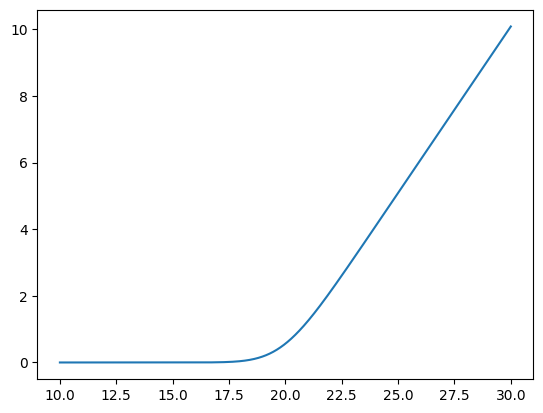

In [11]:
sns.lineplot(x=np.linspace(10, 30, 1001), y=implicit_call_prices[:, 40])

Now for the compound option $K$, we will use the payoff

$$
    \max\{c - 2, 0\}
$$
Where $c$ is the price of the call option at $t = 1/4$. Note that $k\Delta t = 1/4 \iff k = \frac{1}{4\Delta t} = 25$ 

In [ ]:
implicit_payoff = implicit_call_prices[:, 24] - 2
implicit_payoff[implicit_payoff < 0] = 0

cn_payoff = cn_call_prices[:, 24] - 2
cn_payoff[cn_payoff < 0] = 0

compound_implicit_prices = compound_implicit_solver(
    dt=0.01,
    dx=0.02,
    r=0.05,
    gamma=0.8,
    sigma=0.4,
    T=0.25,
    x_range=(10, 30),
    payoff=implicit_payoff
)

'''
cn_implicit_prices = compound_crank_nicolson_solver(
    dt=0.01,
    dx=0.02,
    r=0.05,
    gamma=0.8,
    sigma=0.4,
    T=0.25,
    x_range=(10, 30),
    payoff=cn_payoff
)
'''

'\ncn_implicit_prices = compound_crank_nicolson_solver(\n    dt=0.01,\n    dx=0.02,\n    r=0.05,\n    gamma=0.8,\n    sigma=0.4,\n    T=0.25,\n    x_range=(10, 30),\n    payoff=implicit_payoff\n)\n'

<Axes: >

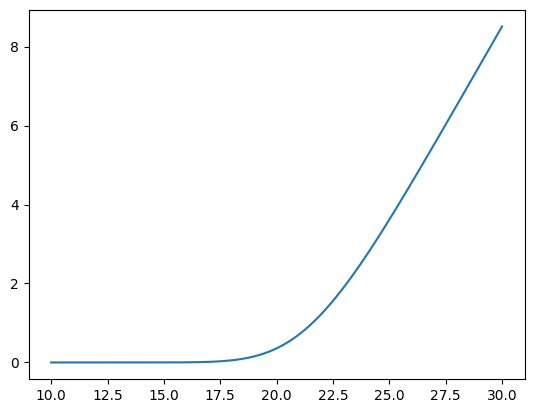

In [16]:
sns.lineplot(x=np.linspace(10, 30, 1001), y=compound_implicit_prices[:, 0])

# Question 2

## (a)

For the model
$$
    \begin{align*}
        &dS_t = rS_t dt + S_t \sqrt{V_t} dW^{1}_t \\
        &dV_t = \kappa (\theta - V_t) dt + \eta \sqrt{V_t} dW^{2}_t \\
        &d\langle W^{1}_{t}, W^{2}_t \rangle = \rho
    \end{align*}
$$

We have that the price for a Put option $P(t, s, v)$ satisfies
$$
    \begin{align*}
        &\frac{\partial P}{\partial t} + rs \frac{\partial P}{\partial s} + s^2 v \frac{\partial^2 P}{\partial s^2} +\\
        &\kappa(\theta - v) \frac{\partial P}{\partial v} + \eta^2 v \frac{\partial^2 P}{\partial v^2} + \rho \eta sv \frac{\partial^2 P}{\partial s \partial v} - rP = 0
    \end{align*}
$$